In [14]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
snehangsude_audible_dataset_path = kagglehub.dataset_download('snehangsude/audible-dataset')

print('Data source import complete.')


Data source import complete.


# 1. INTRODUCTION

In this notebook, we will analyze and model the Audible dataset available at:
https://www.kaggle.com/datasets/snehangsude/audible-dataset

**Column Breakdown:**
- name - Name of the audiobook
- author - Author of the audiobook
- narrator - Narrator of the audiobook
- time - Length of the audiobook (string indicating hours/minutes)
- releasedate - Release date of the audiobook (YYYY-MM-DD format)
- language - Language of the audiobook
- stars - Number of stars the audiobook received (float or integer)
- price - Price of the audiobook in INR (float or integer)
- ratings - Number of reviews/ratings received by the audiobook (int)

**Project Objectives:**
1. Perform thorough data cleaning and preprocessing, dealing with missing values, formatting columns (time and date), handling outliers, etc.
2. Conduct extensive Exploratory Data Analysis (EDA) with various graphs, correlation analysis, and descriptive statistics.
3. Build two different predictive models to demonstrate different approaches: (a) Classification: Predict whether an audiobook has “high” or “low” star rating.
4. Perform hyperparameter tuning and compare performance using appropriate metrics.
5. Provide clear visualizations (box plots, histograms, bar plots, correlation heatmap, etc.) to gain insights into the dataset.

### 2. IMPORTING LIBRARIES

In [18]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, mean_squared_error, r2_score
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score

In [47]:
import warnings
warnings.filterwarnings('ignore')

### 3. LOADING THE DATASET


In [20]:
data_path = snehangsude_audible_dataset_path + "/audible_uncleaned.csv"
df = pd.read_csv(data_path)

In [23]:
# Quick peek at the dataset
print("Initial DataFrame Shape:", df.shape)
print("Column Names:", df.columns.tolist())

Initial DataFrame Shape: (87489, 8)
Column Names: ['name', 'author', 'narrator', 'time', 'releasedate', 'language', 'stars', 'price']


In [25]:
df.head()

,name,author,narrator,time,releasedate,language,stars,price
0,Geronimo Stilton #11 & #12,Writtenby:GeronimoStilton,Narratedby:BillLobely,2 hrs and 20 mins,04-08-08,English,5 out of 5 stars34 ratings,468.00
1,The Burning Maze,Writtenby:RickRiordan,Narratedby:RobbieDaymond,13 hrs and 8 mins,01-05-18,English,4.5 out of 5 stars41 ratings,820.00
2,The Deep End,Writtenby:JeffKinney,Narratedby:DanRussell,2 hrs and 3 mins,06-11-20,English,4.5 out of 5 stars38 ratings,410.00
3,Daughter of the Deep,Writtenby:RickRiordan,Narratedby:SoneelaNankani,11 hrs and 16 mins,05-10-21,English,4.5 out of 5 stars12 ratings,615.00
4,"The Lightning Thief: Percy Jackson, Book 1",Writtenby:RickRiordan,Narratedby:JesseBernstein,10 hrs,13-01-10,English,4.5 out of 5 stars181 ratings,820.00


### 4. BASIC DATA OVERVIEW


In [28]:
print("\n===== BASIC INFORMATION =====\n")
df.info()    # Check column data types and non-null count


===== BASIC INFORMATION =====

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87489 entries, 0 to 87488
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   name         87489 non-null  object
 1   author       87489 non-null  object
 2   narrator     87489 non-null  object
 3   time         87489 non-null  object
 4   releasedate  87489 non-null  object
 5   language     87489 non-null  object
 6   stars        87489 non-null  object
 7   price        87489 non-null  object
dtypes: object(8)
memory usage: 5.3+ MB


In [30]:
print("\n===== DESCRIPTION (OBJECT COLUMNS) =====\n")
print(df.describe(include=[object]))


===== DESCRIPTION (OBJECT COLUMNS) =====

                  name              author              narrator    time  \
count            87489               87489                 87489   87489   
unique           82767               48374                 29717    2284   
top     The Art of War  Writtenby:矢島雅弘,石橋遊  Narratedby:anonymous  2 mins   
freq                20                 874                  1034     372   

       releasedate language          stars   price  
count        87489    87489          87489   87489  
unique        5058       36            665    1011  
top       16-05-18  English  Not rated yet  586.00  
freq           773    61884          72417    5533  


In [32]:
# Check for duplicates
duplicate_rows = df.duplicated(subset=["name", "author", "narrator"], keep=False)
print(f"\nNumber of duplicated rows (name+author+narrator): {duplicate_rows.sum()}")


Number of duplicated rows (name+author+narrator): 775


### 5. DATA CLEANING AND PREPROCESSING

In [35]:
print("\n===== CHECKING MISSING VALUES =====\n")
missing = df.isnull().sum()
print(missing)


===== CHECKING MISSING VALUES =====

name           0
author         0
narrator       0
time           0
releasedate    0
language       0
stars          0
price          0
dtype: int64


In [37]:
if df['language'].isnull().sum() > 0:
    df['language'].fillna('Unknown', inplace=True)

In [39]:
if df['stars'].isnull().sum() > 0:
    stars_median = df['stars'].median()
    df['stars'].fillna(stars_median, inplace=True)

In [41]:
df.head()

,name,author,narrator,time,releasedate,language,stars,price
0,Geronimo Stilton #11 & #12,Writtenby:GeronimoStilton,Narratedby:BillLobely,2 hrs and 20 mins,04-08-08,English,5 out of 5 stars34 ratings,468.00
1,The Burning Maze,Writtenby:RickRiordan,Narratedby:RobbieDaymond,13 hrs and 8 mins,01-05-18,English,4.5 out of 5 stars41 ratings,820.00
2,The Deep End,Writtenby:JeffKinney,Narratedby:DanRussell,2 hrs and 3 mins,06-11-20,English,4.5 out of 5 stars38 ratings,410.00
3,Daughter of the Deep,Writtenby:RickRiordan,Narratedby:SoneelaNankani,11 hrs and 16 mins,05-10-21,English,4.5 out of 5 stars12 ratings,615.00
4,"The Lightning Thief: Percy Jackson, Book 1",Writtenby:RickRiordan,Narratedby:JesseBernstein,10 hrs,13-01-10,English,4.5 out of 5 stars181 ratings,820.00


In [43]:
def convert_time_to_hours(time_str):
    """
    Converts strings like "7 hrs and 45 mins" to float hours, e.g., 7.75.
    Handles cases like "7 hrs", "45 mins", "7hr and 30min", etc.
    Returns np.nan for invalid or missing inputs.
    """
    # try:
    if not time_str or not isinstance(time_str, str):
        return np.nan

    time_str = time_str.lower().strip()

    # Initialize
    hrs = 0
    mins = 0

    # Find numbers using regex
    hr_match = re.search(r'(\d+\.?\d*)\s*hr', time_str)
    min_match = re.search(r'(\d+\.?\d*)\s*min', time_str)

    if hr_match:
        hrs = float(hr_match.group(1))

    if min_match:
        mins = float(min_match.group(1))

    total_hrs = hrs + (mins / 60.0)
    return total_hrs
    # except:
        # return np.nan

In [49]:
df['time_hours'] = df['time'].apply(convert_time_to_hours)
print("\nConverted 'time' column to numeric 'time_hours' (float).")


Converted 'time' column to numeric 'time_hours' (float).


In [51]:
 # Converting 'releasedate' to datetime
df['releasedate'] = pd.to_datetime(df['releasedate'], errors='coerce')

In [53]:
# Create additional date features
df['release_year'] = df['releasedate'].dt.year
df['release_month'] = df['releasedate'].dt.month
df['release_day'] = df['releasedate'].dt.day

In [55]:
# Handle invalid or missing releasedate
invalid_dates = df['releasedate'].isnull().sum()
print(f"\nNumber of invalid or missing release dates: {invalid_dates}")


Number of invalid or missing release dates: 0


In [57]:
def clean_price(p):
    try:
        if not isinstance(p, str):
            return np.nan
        # Remove anything that's not a digit or a dot (decimal point)
        p = re.sub(r'[^\d.]', '', p)
        if p == '':
            return np.nan
        return float(p)
    except:
        return np.nan

In [59]:
df['price'] = df['price'].apply(clean_price)

In [61]:
# Function to parse rating and number of ratings
def parse_rating(text):
    try:
        if not isinstance(text, str):
            return 0, 0
        if 'not rated' in text.lower():
            return 0, 0
        rating_match = re.search(r'(\d+\.?\d*)\s*out of\s*5', text.lower())
        count_match = re.search(r'(\d+)\s*ratings', text.lower())
        rating = float(rating_match.group(1)) if rating_match else np.nan
        count = int(count_match.group(1)) if count_match else np.nan
        return rating, count
    except:
        return 0, 0

In [63]:
# Apply parsing
df[['rating', 'num_ratings']] = df['stars'].apply(lambda x: pd.Series(parse_rating(x)))

In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87489 entries, 0 to 87488
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   name           87489 non-null  object        
 1   author         87489 non-null  object        
 2   narrator       87489 non-null  object        
 3   time           87489 non-null  object        
 4   releasedate    87489 non-null  datetime64[ns]
 5   language       87489 non-null  object        
 6   stars          87489 non-null  object        
 7   price          87151 non-null  float64       
 8   time_hours     87489 non-null  float64       
 9   release_year   87489 non-null  int32         
 10  release_month  87489 non-null  int32         
 11  release_day    87489 non-null  int32         
 12  rating         87489 non-null  float64       
 13  num_ratings    81667 non-null  float64       
dtypes: datetime64[ns](1), float64(4), int32(3), object(6)
memory usage: 8.

In [67]:
# Outlier Detection & Treatment
before_rows = df.shape[0]
upper_price_limit = df['price'].quantile(0.99)  # 99th percentile
df_new = df[df['price'] <= upper_price_limit]

df_new = df_new[df_new['rating'] <= df_new['rating'].quantile(0.99)]

time_upper_limit = df_new['time_hours'].quantile(0.99)
df_new = df_new[df_new['time_hours'] <= time_upper_limit]

after_rows = df_new.shape[0]
print(f"\nNumber of rows before outlier removal: {before_rows}")
print(f"Number of rows after outlier removal: {after_rows}")

print("\nCleaned DataFrame Shape:", df_new.shape)





Number of rows before outlier removal: 87489
Number of rows after outlier removal: 85500

Cleaned DataFrame Shape: (85500, 14)


### 6. EXPLORATORY DATA ANALYSIS (EDA)


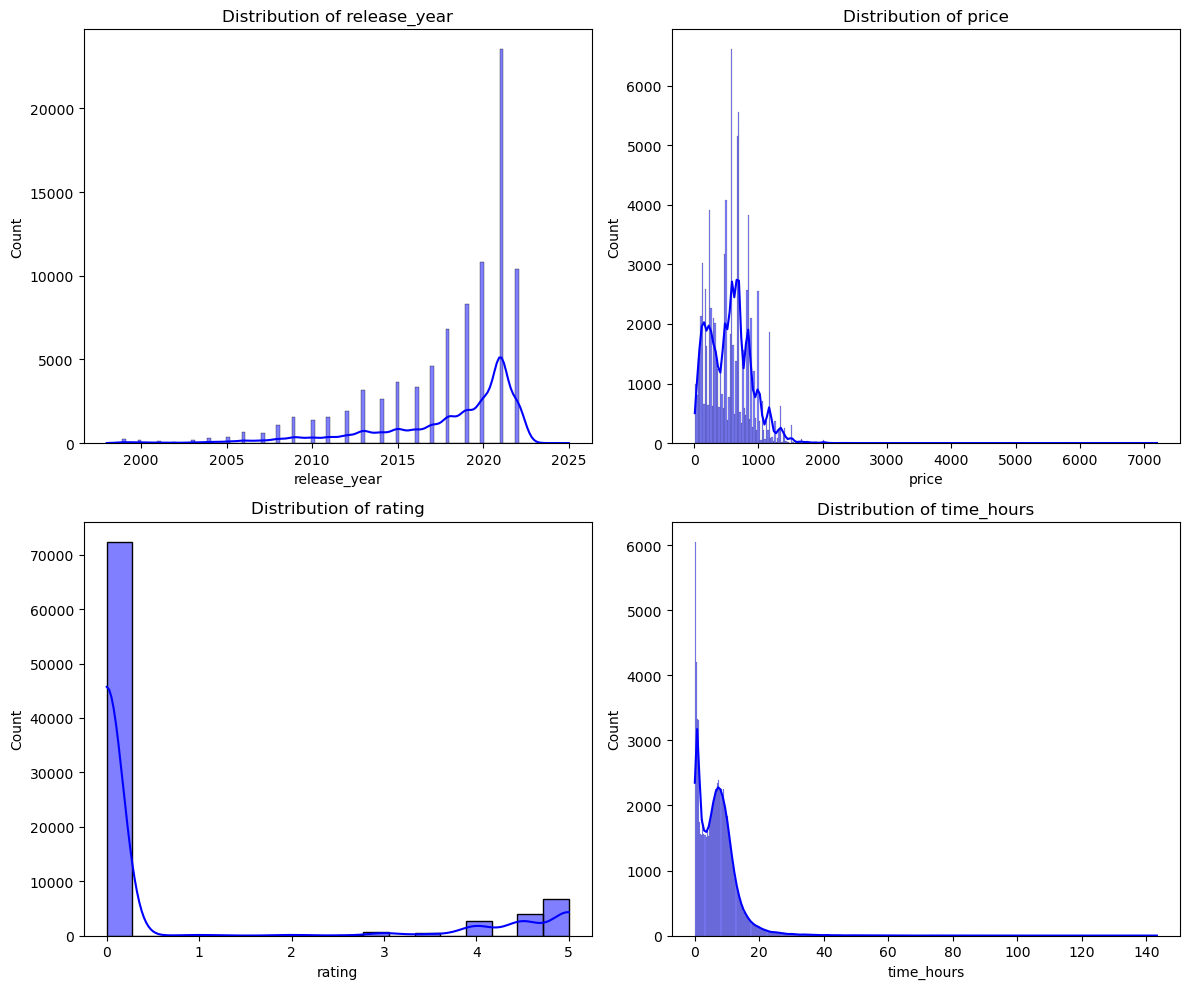

In [70]:
# Distribution Plots for Numeric Columns
numeric_cols = ['release_year', 'price', 'rating', 'time_hours']

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for ax, col in zip(axes, numeric_cols):
    sns.histplot(data=df, x=col, kde=True, ax=ax, color='blue')
    ax.set_title(f"Distribution of {col}")

plt.tight_layout()
plt.show()

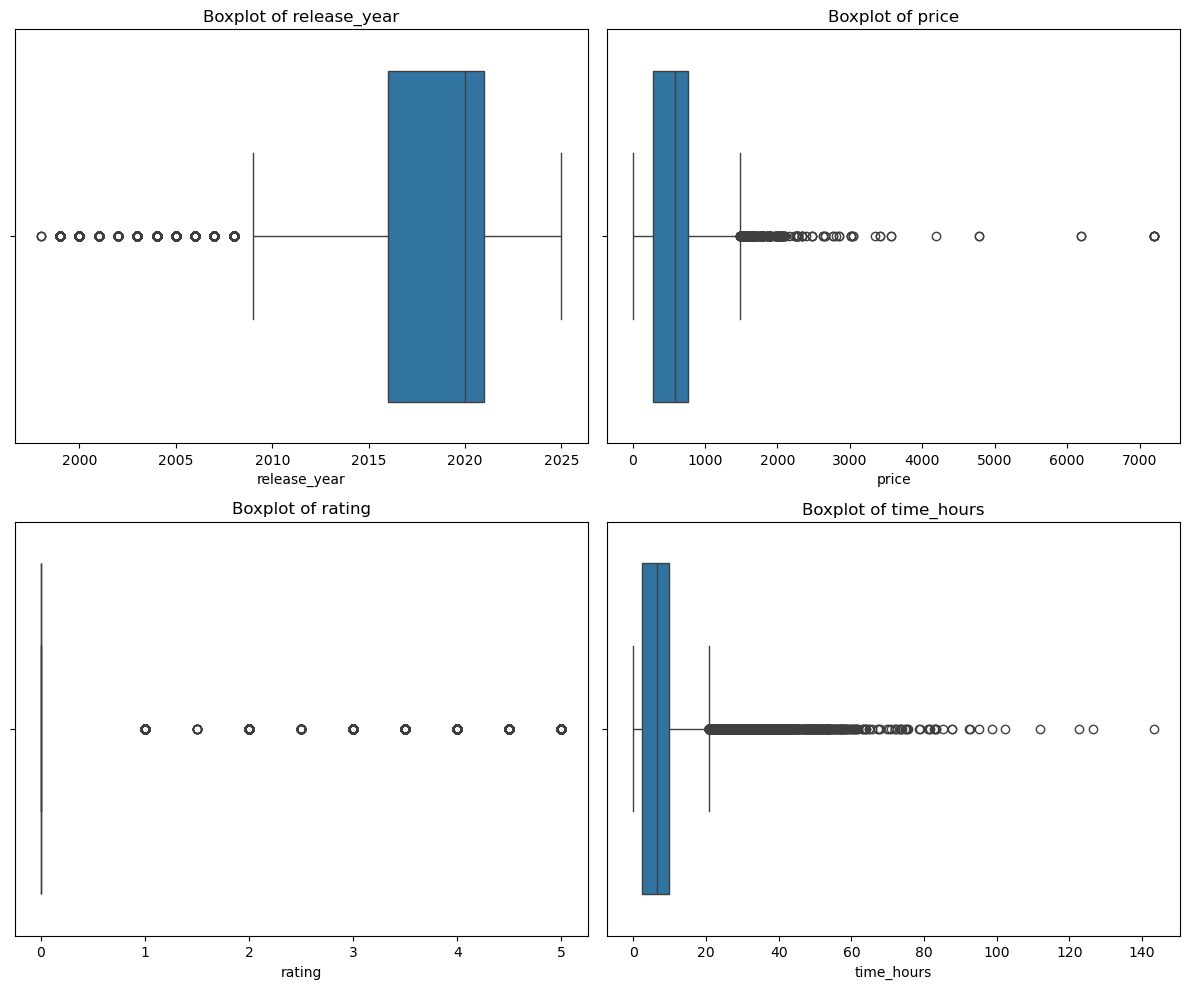

In [72]:
# Box Plots to detect any anomalies visually
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for ax, col in zip(axes, numeric_cols):
    sns.boxplot(data=df, x=col, ax=ax)
    ax.set_title(f"Boxplot of {col}")

plt.tight_layout()
plt.show()



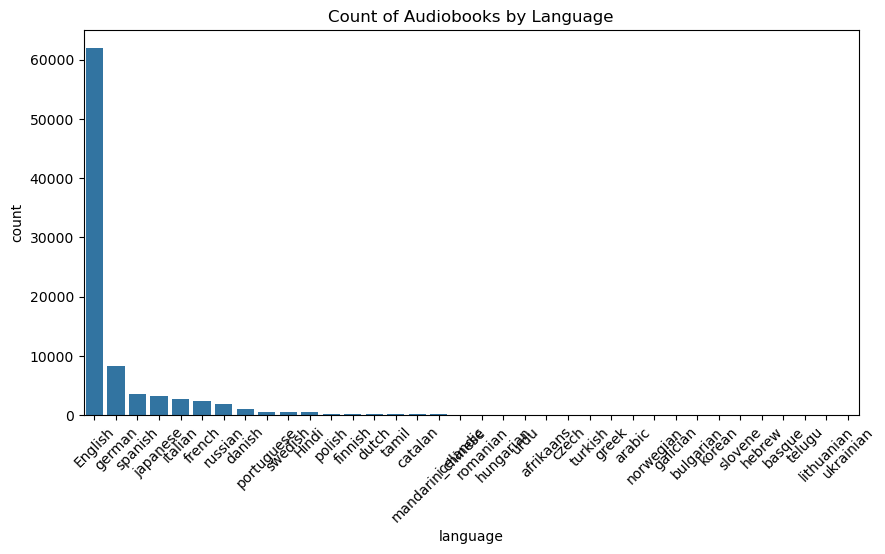

In [74]:
# Categorical Plots: language
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x='language', order=df['language'].value_counts().index)
plt.xticks(rotation=45)
plt.title("Count of Audiobooks by Language")
plt.show()

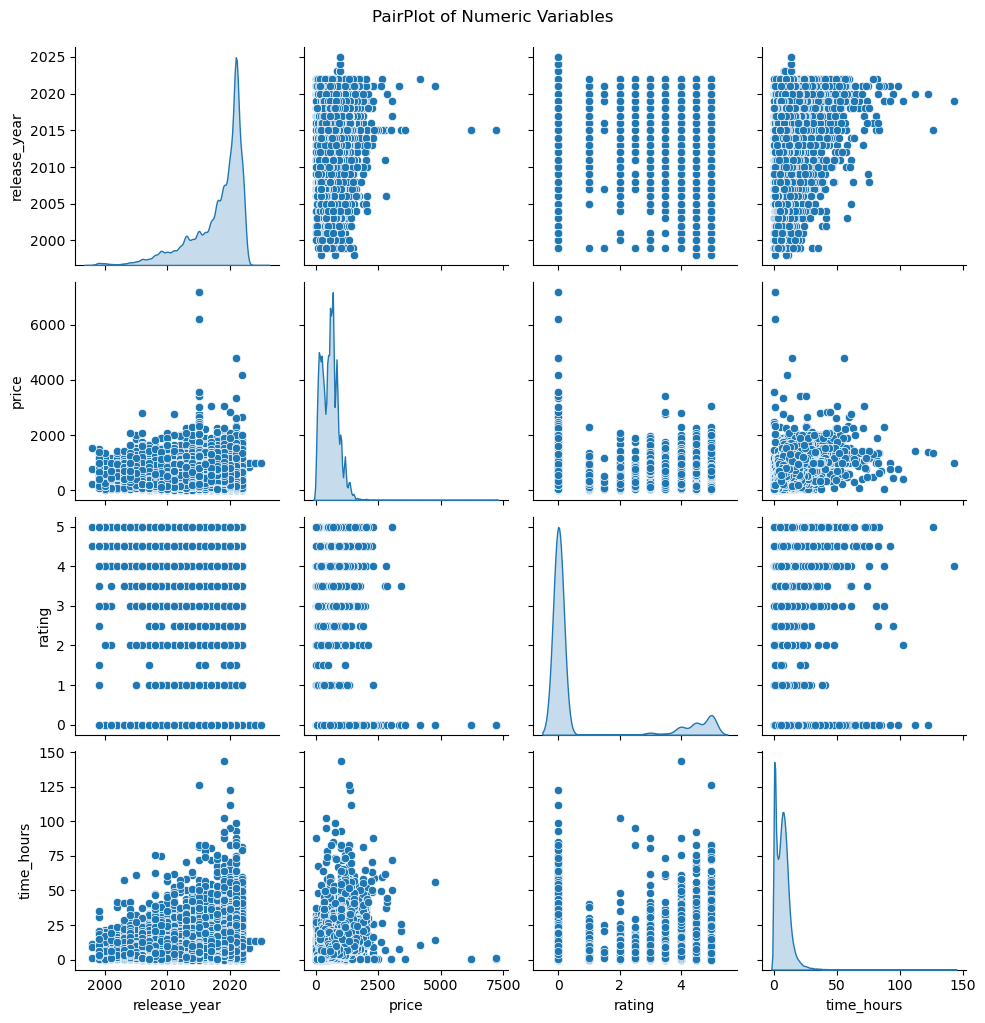

In [76]:
# Relationship between numeric variables: pairplot
sns.pairplot(df[numeric_cols], diag_kind='kde')
plt.suptitle("PairPlot of Numeric Variables", y=1.02)
plt.show()

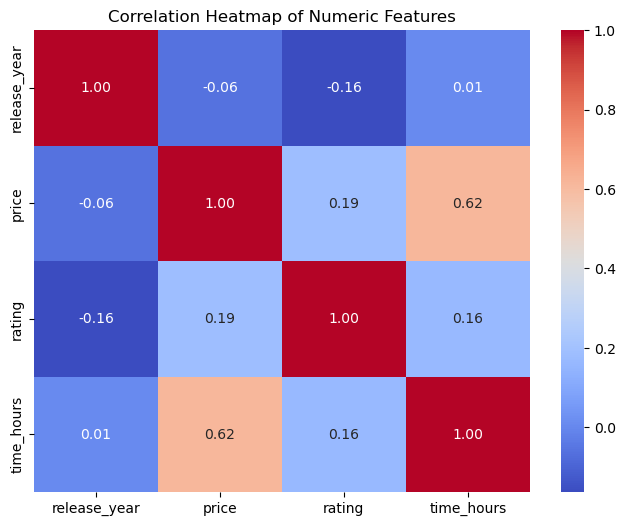

In [78]:
# Correlation Matrix
corr_matrix = df[numeric_cols].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap of Numeric Features")
plt.show()

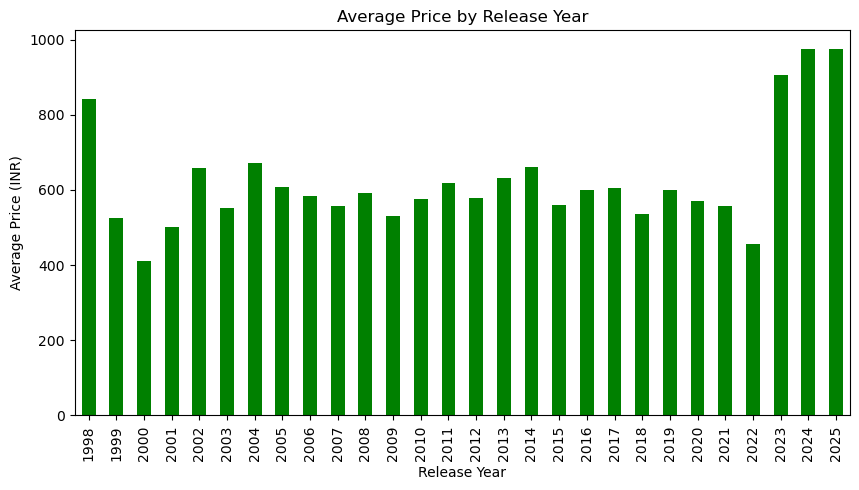

In [80]:
# Average price per release_year
avg_price_by_year = df.groupby('release_year')['price'].mean()
plt.figure(figsize=(10,5))
avg_price_by_year.plot(kind='bar', color='green')
plt.title("Average Price by Release Year")
plt.xlabel("Release Year")
plt.ylabel("Average Price (INR)")
plt.show()

# 7. FEATURE ENGINEERING


In [83]:
df.head()

,name,author,narrator,time,releasedate,language,stars,price,time_hours,release_year,release_month,release_day,rating,num_ratings
0,Geronimo Stilton #11 & #12,Writtenby:GeronimoStilton,Narratedby:BillLobely,2 hrs and 20 mins,2008-04-08,English,5 out of 5 stars34 ratings,468.0,2.333333,2008,4,8,5.0,34.0
1,The Burning Maze,Writtenby:RickRiordan,Narratedby:RobbieDaymond,13 hrs and 8 mins,2018-01-05,English,4.5 out of 5 stars41 ratings,820.0,13.133333,2018,1,5,4.5,41.0
2,The Deep End,Writtenby:JeffKinney,Narratedby:DanRussell,2 hrs and 3 mins,2020-06-11,English,4.5 out of 5 stars38 ratings,410.0,2.050000,2020,6,11,4.5,38.0
3,Daughter of the Deep,Writtenby:RickRiordan,Narratedby:SoneelaNankani,11 hrs and 16 mins,2021-05-10,English,4.5 out of 5 stars12 ratings,615.0,11.266667,2021,5,10,4.5,12.0
4,"The Lightning Thief: Percy Jackson, Book 1",Writtenby:RickRiordan,Narratedby:JesseBernstein,10 hrs,2010-01-13,English,4.5 out of 5 stars181 ratings,820.0,10.000000,2010,1,13,4.5,181.0


In [85]:
def classify_star_rating(star_value, threshold=3.0):
    return 1 if star_value >= threshold else 0

df['star_class'] = df['rating'].apply(classify_star_rating)

In [87]:
df['author'] = df['author'].apply(lambda x : x.split(":")[-1])

In [89]:
df['narrator'] = df['narrator'].apply(lambda x : x.split(":")[-1])

In [91]:
model_features_classification = ['author_encoded',	'narrator_encoded','time_hours','price','num_ratings','language_encoded','release_year','release_month']
target_classification = 'star_class'

In [93]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87489 entries, 0 to 87488
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   name           87489 non-null  object        
 1   author         87489 non-null  object        
 2   narrator       87489 non-null  object        
 3   time           87489 non-null  object        
 4   releasedate    87489 non-null  datetime64[ns]
 5   language       87489 non-null  object        
 6   stars          87489 non-null  object        
 7   price          87151 non-null  float64       
 8   time_hours     87489 non-null  float64       
 9   release_year   87489 non-null  int32         
 10  release_month  87489 non-null  int32         
 11  release_day    87489 non-null  int32         
 12  rating         87489 non-null  float64       
 13  num_ratings    81667 non-null  float64       
 14  star_class     87489 non-null  int64         
dtypes: datetime64[ns](1

In [95]:
# encoding Object Columns
le_lang = LabelEncoder()
df['language_encoded'] = le_lang.fit_transform(df['language'])

le_author = LabelEncoder()
df['author_encoded'] = le_author.fit_transform(df['author'])

le_narrator = LabelEncoder()
df['narrator_encoded'] = le_narrator.fit_transform(df['narrator'])

In [97]:
price_median = df['price'].median()
df['price'].fillna(price_median, inplace=True)

In [99]:
ratings_median = df['num_ratings'].median()
df['num_ratings'].fillna(ratings_median, inplace=True)

In [101]:
# CLASSIFICATION MODEL (Predicting High vs Low Star Rating)
# Split data
X_class = df[model_features_classification].copy()
y_class = df[target_classification].copy()

In [103]:
# Create train/test split

Xc_train, Xc_test, yc_train, yc_test = train_test_split(X_class, y_class, test_size=0.2, random_state=42, stratify=y_class)

In [105]:
print("\n===== CLASSIFICATION DATA SHAPES =====")
print("Xc_train:", Xc_train.shape, "| yc_train:", yc_train.shape)
print("Xc_test: ", Xc_test.shape,  "| yc_test: ", yc_test.shape)


===== CLASSIFICATION DATA SHAPES =====
Xc_train: (69991, 8) | yc_train: (69991,)
Xc_test:  (17498, 8) | yc_test:  (17498,)


In [107]:
Xc_train = Xc_train.iloc[:9991,]
yc_train = yc_train.iloc[:9991,]
Xc_test = Xc_test.iloc[:7498,]
yc_test = yc_test.iloc[:7498,]

In [109]:
# Logistic Regression with GridSearch
log_reg = LogisticRegression(solver='liblinear')
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2']
}

grid_lr = GridSearchCV(log_reg, param_grid_lr, scoring='accuracy', cv=3, n_jobs=-1)
grid_lr.fit(Xc_train, yc_train)

GridSearchCV(cv=3, estimator=LogisticRegression(solver='liblinear'), n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 10], 'penalty': ['l1', 'l2']},
             scoring='accuracy')

In [111]:
# Evaluate on test set
lr_preds = grid_lr.predict(Xc_test)
lr_acc = accuracy_score(yc_test, lr_preds)
print(f"Logistic Regression Accuracy: {lr_acc:.4f}")

Logistic Regression Accuracy: 0.9369


In [113]:
# Classification report
print("\nLogistic Regression Classification Report:")
print(classification_report(yc_test, lr_preds))


Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.93      1.00      0.96      6286
           1       1.00      0.61      0.76      1212

    accuracy                           0.94      7498
   macro avg       0.96      0.81      0.86      7498
weighted avg       0.94      0.94      0.93      7498



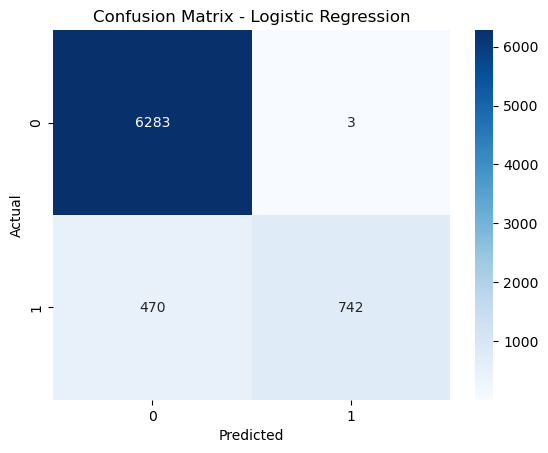

In [115]:
# Confusion matrix
cm_lr = confusion_matrix(yc_test, lr_preds)
sns.heatmap(cm_lr, annot=True, cmap="Blues", fmt='d')
plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [117]:
# Random Forest Classifier with GridSearch
rf_clf = RandomForestClassifier()
param_grid_rf = {
    'n_estimators': [50, 100],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5]
}

grid_rf = GridSearchCV(rf_clf, param_grid_rf, scoring='accuracy', cv=3, n_jobs=-1)
grid_rf.fit(Xc_train, yc_train)

GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [None, 5, 10],
                         'min_samples_split': [2, 5],
                         'n_estimators': [50, 100]},
             scoring='accuracy')

In [119]:
print("\n===== BEST RANDOM FOREST CLASSIFIER PARAMS =====")
print(grid_rf.best_params_)
best_rf_clf = grid_rf.best_estimator_

# Evaluate
rf_preds = best_rf_clf.predict(Xc_test)
rf_acc = accuracy_score(yc_test, rf_preds)
print(f"Random Forest Accuracy: {rf_acc:.4f}")


===== BEST RANDOM FOREST CLASSIFIER PARAMS =====
{'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 50}
Random Forest Accuracy: 0.9372


In [121]:
# Classification report
print("\nRandom Forest Classification Report:")
print(classification_report(yc_test, rf_preds))


Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.93      1.00      0.96      6286
           1       1.00      0.61      0.76      1212

    accuracy                           0.94      7498
   macro avg       0.96      0.81      0.86      7498
weighted avg       0.94      0.94      0.93      7498



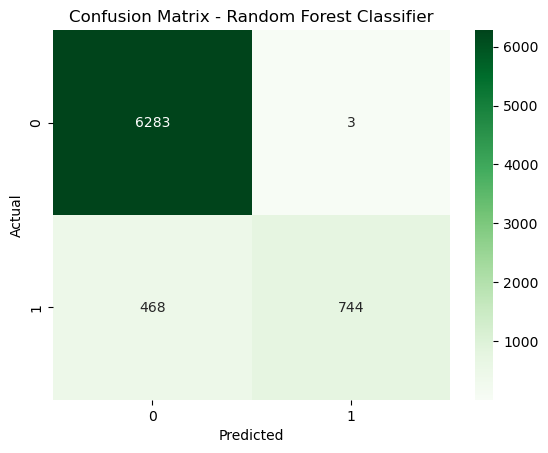

In [123]:
# Confusion matrix
cm_rf = confusion_matrix(yc_test, rf_preds)
sns.heatmap(cm_rf, annot=True, cmap="Greens", fmt='d')
plt.title("Confusion Matrix - Random Forest Classifier")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

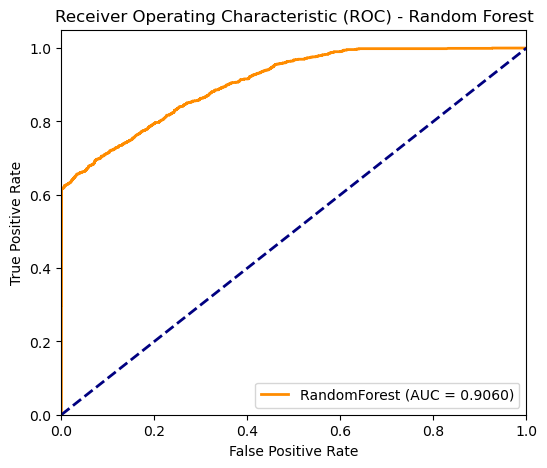

In [125]:
#  ROC Curve for best model
rf_proba = best_rf_clf.predict_proba(Xc_test)[:,1]
fpr, tpr, thresholds = roc_curve(yc_test, rf_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'RandomForest (AUC = {roc_auc:.4f})')
plt.plot([0,1], [0,1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) - Random Forest")
plt.legend(loc="lower right")
plt.show()